<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-nruh3upf
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-nruh3upf
     |████████████████████████████████| 153kB 11.9MB/s 
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-zqcw_ep7/pyfolio
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-zqcw_ep7/pyfolio
     |████████████████████████████████| 5.5MB 15.7MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
  Created wheel for finrl: filename=finrl-0.0.1-cp36-none-any.whl size=26642 sha256=233318e3cb0f70872097d94f8c581dd55771c3818cb54dfa32c46016ccb4b5ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-u_jxxdbk/wheels/9c/19/bf/c644def96612df1ad42c94d5304966797eaa3221dffc5efe0b
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22615 sha256=43e2792cf0893dc44a870ced35772bd28c8ff0438cc3ec6103e23612a7e831fd



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas','numpy', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow','pyfolio'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines3[extra]
    !pip install git+https://github.com/quantopian/pyfolio


  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-kocy0hrp


<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.environment import EnvSetup
from finrl.env.EnvMultipleStock_train import StockEnvTrain
from finrl.env.EnvMultipleStock_trade import StockEnvTrade
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot



/opt/conda/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [4]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [5]:
# from config.py end_date is a string
config.END_DATE

'2020-12-01'

In [6]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [7]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2020-12-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
df.shape

(89970, 7)

In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic
0,2009-01-02,3.067143,3.251429,3.041429,2.795913,746015200.0,AAPL
1,2009-01-02,18.570000,19.520000,18.400000,15.800624,10955700.0,AXP
2,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA
3,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT
4,2009-01-02,16.410000,17.000000,16.250000,12.786087,40980600.0,CSCO


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [10]:
df = FeatureEngineer(df.copy(),
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False).preprocess_data()

Successfully added technical indicators
Successfully added turbulence index


In [11]:
df.sort_values(['date','tic'],ignore_index=True).head(10)

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.795913,746015200.0,AAPL,0.0,100.0,66.666667,100.0,0.0
1,2009-01-02,18.570000,19.520000,18.400000,15.800624,10955700.0,AXP,0.0,100.0,66.666667,100.0,0.0
2,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA,0.0,100.0,66.666667,100.0,0.0
3,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT,0.0,100.0,66.666667,100.0,0.0
4,2009-01-02,16.410000,17.000000,16.250000,12.786087,40980600.0,CSCO,0.0,100.0,66.666667,100.0,0.0
5,2009-01-02,74.230003,77.300003,73.580002,48.043262,13695900.0,CVX,0.0,100.0,66.666667,100.0,0.0
6,2009-01-02,21.605234,22.060680,20.993229,14.527276,13251000.0,DD,0.0,100.0,66.666667,100.0,0.0
7,2009-01-02,22.760000,24.030001,22.500000,20.597496,9796600.0,DIS,0.0,100.0,66.666667,100.0,0.0
8,2009-01-02,84.019997,87.620003,82.190002,72.844467,14088500.0,GS,0.0,100.0,66.666667,100.0,0.0
9,2009-01-02,23.070000,24.190001,22.959999,17.909452,14902500.0,HD,0.0,100.0,66.666667,100.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2018-12-31
## Trade data split: 2019-01-01 to 2020-09-30

In [12]:
train = data_split(df, '2009-01-01','2019-01-01')
trade = data_split(df, '2019-01-01','2020-12-01')


In [13]:
train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.795913,746015200.0,AAPL,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,18.570000,19.520000,18.400000,15.800624,10955700.0,AXP,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,16.410000,17.000000,16.250000,12.786087,40980600.0,CSCO,0.0,100.0,66.666667,100.0,0.0


In [14]:
trade.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2019-01-02,38.722500,39.712502,38.557499,38.562561,148158800.0,AAPL,-2.019903,37.867349,-91.567852,42.250808,119.879197
0,2019-01-02,93.910004,96.269997,93.769997,92.643311,4175400.0,AXP,-3.426008,41.204982,-97.742269,26.709417,119.879197
0,2019-01-02,316.190002,323.950012,313.709991,314.645142,3292200.0,BA,-5.550592,47.010000,-21.712382,13.611972,119.879197
0,2019-01-02,124.029999,127.879997,123.000000,119.302582,4783200.0,CAT,-0.686759,48.229089,-5.091209,0.873482,119.879197
0,2019-01-02,42.279999,43.200001,42.209999,40.382099,23833500.0,CSCO,-0.960061,44.872557,-87.496850,29.529377,119.879197


In [15]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 181


In [16]:
env_setup = EnvSetup(stock_dim = stock_dimension,
                        state_space = state_space,
                        hmax = 100,
                        initial_amount = 1000000,
                        transaction_cost_pct = 0.001)

## Environment for Training



In [17]:
env_train = env_setup.create_env_training(data = train,
                                          env_class = StockEnvTrain)

## Environment for Trading



In [18]:
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade) 

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [19]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [20]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
a2c_params_tuning = {'n_steps':5, 
			  'ent_coef':0.005, 
			  'learning_rate':0.0002,
			  'verbose':0,
			  'timesteps':150000}
model_a2c = agent.train_A2C(model_name = "A2C_{}".format(now), model_params = a2c_params_tuning)

==============Model Training===========


/opt/conda/lib/python3.6/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU1 GeForce GTX 760 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


begin_total_asset:1000000
end_total_asset:5784807.489077928
total_reward:4784807.489077928
total_cost:  171261.18329014312
total_trades:  66681
Sharpe:  1.158384297778545
begin_total_asset:1000000
end_total_asset:6129139.166672241
total_reward:5129139.166672241
total_cost:  171407.4013669429
total_trades:  66727
Sharpe:  1.1511288534069641
begin_total_asset:1000000
end_total_asset:3884702.706202592
total_reward:2884702.706202592
total_cost:  184465.7187718543
total_trades:  67589
Sharpe:  0.9857818017305219
begin_total_asset:1000000
end_total_asset:6400715.897313735
total_reward:5400715.897313735
total_cost:  172584.2798994141
total_trades:  66016
Sharpe:  1.1758434603625492
begin_total_asset:1000000
end_total_asset:5002705.819736808
total_reward:4002705.8197368076
total_cost:  200837.72079600804
total_trades:  67515
Sharpe:  1.0793254257378413
begin_total_asset:1000000
end_total_asset:3988230.9030086207
total_reward:2988230.9030086207
total_cost:  215942.0191006974
total_trades:  6883

KeyboardInterrupt: 

### Model 2: DDPG

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ddpg_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':100000, 
                     'learning_rate':0.001,
			               'verbose':0,
			               'timesteps':50000}
model_ddpg = agent.train_DDPG(model_name = "DDPG_{}".format(now), model_params = ddpg_params_tuning)

### Model 3: PPO

In [39]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ppo_params_tuning = {'n_steps':128, 
                     'batch_size': 64,
			               'ent_coef':0.005, 
			               'learning_rate':0.00025,
			              'verbose':0,
			              'timesteps':50000}
model_ppo = agent.train_PPO(model_name = "PPO_{}".format(now), model_params = ppo_params_tuning)

==============Model Training===========
begin_total_asset:1000000
end_total_asset:2819323.576565122
total_reward:1819323.5765651222
total_cost:  224368.3155249093
total_trades:  70871
Sharpe:  0.8005221030112711
begin_total_asset:1000000
end_total_asset:3022860.507894876
total_reward:2022860.507894876
total_cost:  193015.01653625682
total_trades:  69041
Sharpe:  0.8526035280917981
begin_total_asset:1000000
end_total_asset:3384146.471590083
total_reward:2384146.471590083
total_cost:  178021.07423216227
total_trades:  67657
Sharpe:  0.8974617065191731
begin_total_asset:1000000
end_total_asset:4270044.637443882
total_reward:3270044.6374438824
total_cost:  129230.60205143875
total_trades:  62436
Sharpe:  0.9766714352452907
begin_total_asset:1000000
end_total_asset:4416078.22062774
total_reward:3416078.22062774
total_cost:  102205.87894165136
total_trades:  59850
Sharpe:  0.9411850131592205
begin_total_asset:1000000
end_total_asset:4155855.157128676
total_reward:3155855.157128676
total_cost

### Model 4: TD3

In [32]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
td3_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':200000, 
                     'learning_rate': 0.0002,
			               'verbose':0,
			               'timesteps':50000}
model_td3 = agent.train_TD3(model_name = "TD3_{}".format(now), model_params = td3_params_tuning)

==============Model Training===========
begin_total_asset:1000000
end_total_asset:3793389.552001066
total_reward:2793389.552001066
total_cost:  5443.014738245419
total_trades:  44934
Sharpe:  0.9401639598816984
begin_total_asset:1000000
end_total_asset:4672472.770709317
total_reward:3672472.770709317
total_cost:  1581.6147865818782
total_trades:  32804
Sharpe:  1.0060878684479397
begin_total_asset:1000000
end_total_asset:4024722.0668405937
total_reward:3024722.0668405937
total_cost:  1083.8276328733223
total_trades:  37772
Sharpe:  0.8948271904236517
begin_total_asset:1000000
end_total_asset:4101403.1330278805
total_reward:3101403.1330278805
total_cost:  1085.250990321056
total_trades:  37773
Sharpe:  0.9000379559231763
begin_total_asset:1000000
end_total_asset:4379168.99165186
total_reward:3379168.99165186
total_cost:  999.0008455756079
total_trades:  40240
Sharpe:  0.9500470297116895
begin_total_asset:1000000
end_total_asset:4412380.716755654
total_reward:3412380.7167556537
total_cos

### Model 5: SAC

In [21]:
env_train = env_setup.create_env_training(data = train,
                                          env_class = StockEnvTrain)
agent = DRLAgent(env = env_train)
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
sac_params_tuning={
  'batch_size': 128,
 'buffer_size': 100000,
  'ent_coef':'auto_0.1',
 'learning_rate': 0.0001,
 'learning_starts':200,
 'timesteps': 40000,
 'verbose': 0}
model_sac = agent.train_SAC(model_name = "SAC_{}".format(now), model_params = sac_params_tuning)

==============Model Training===========
begin_total_asset:1000000
end_total_asset:4382164.2840514295
total_reward:3382164.2840514295
total_cost:  14512.69043110383
total_trades:  36334
Sharpe:  1.1494700817635037
begin_total_asset:1000000
end_total_asset:4955607.994816036
total_reward:3955607.994816036
total_cost:  17928.61809677992
total_trades:  45029
Sharpe:  1.085855072403009
begin_total_asset:1000000
end_total_asset:3971617.1898101172
total_reward:2971617.1898101172
total_cost:  71424.43677836886
total_trades:  47655
Sharpe:  0.8644388344629765
begin_total_asset:1000000
end_total_asset:4063646.421059399
total_reward:3063646.421059399
total_cost:  95564.13759816512
total_trades:  51492
Sharpe:  0.9319558499321027
begin_total_asset:1000000
end_total_asset:6149432.4896843005
total_reward:5149432.4896843005
total_cost:  159127.89068911012
total_trades:  60027
Sharpe:  1.12755778213282
begin_total_asset:1000000
end_total_asset:4544545.271438425
total_reward:3544545.2714384254
total_cos

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be the 99% quantile of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [22]:
data_turbulence = df[(df.date<'2019-01-01') & (df.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [23]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       75.936148
std        38.178007
min         0.000000
25%        58.034373
50%        74.015123
75%        96.948808
max       230.256623
Name: turbulence, dtype: float64

In [24]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [25]:
turbulence_threshold

230.25662291179367

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [40]:
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade,
                                         turbulence_threshold=250) 

df_account_value, df_actions = DRLAgent.DRL_prediction(model=model_ppo,
                        test_data = trade,
                        test_env = env_trade,
                        test_obs = obs_trade)

previous_total_asset:1000000
end_total_asset:1199630.6869821101
total_reward:199630.68698211014
total_cost:  34369.93601973098
total trades:  10558
Sharpe:  0.5832067644087096


In [41]:
df_account_value.shape

(483, 2)

In [42]:
df_account_value.head()

,date,account_value
0,2019-01-02,1.000000e+06
1,2019-01-03,9.977546e+05
2,2019-01-04,1.002576e+06
3,2019-01-07,1.002901e+06
4,2019-01-08,1.004344e+06


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [43]:
print("==============Get Backtest Results===========")
perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  12.141532352760432
sharpe ratio:  0.5832067644087096
Annual return          0.099619
Cumulative returns     0.199631
Annual volatility      0.196530
Sharpe ratio           0.583207
Calmar ratio           0.347330
Stability              0.039632
Max drawdown          -0.286813
Omega ratio            1.119840
Sortino ratio          0.797876
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.092763
Daily value at risk   -0.024306
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
annual return:  15.861453470359743
sharpe ratio:  0.7027424929020084
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (483, 7)


Start date,2019-01-03
End date,2020-11-30
Total months,22
,Backtest
Annual return,13.345%
Cumulative returns,27.074%
Annual volatility,20.956%
Sharpe ratio,0.70
Calmar ratio,0.56
Stability,0.08
Max drawdown,-23.923%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.92,2020-01-16,2020-03-12,2020-09-02,165
1,9.32,2019-02-25,2019-05-31,2019-11-15,190
2,7.04,2020-10-23,2020-10-30,2020-11-09,12
3,6.08,2020-09-02,2020-09-23,2020-10-08,27
4,2.43,2019-11-27,2019-12-03,2019-12-12,12


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


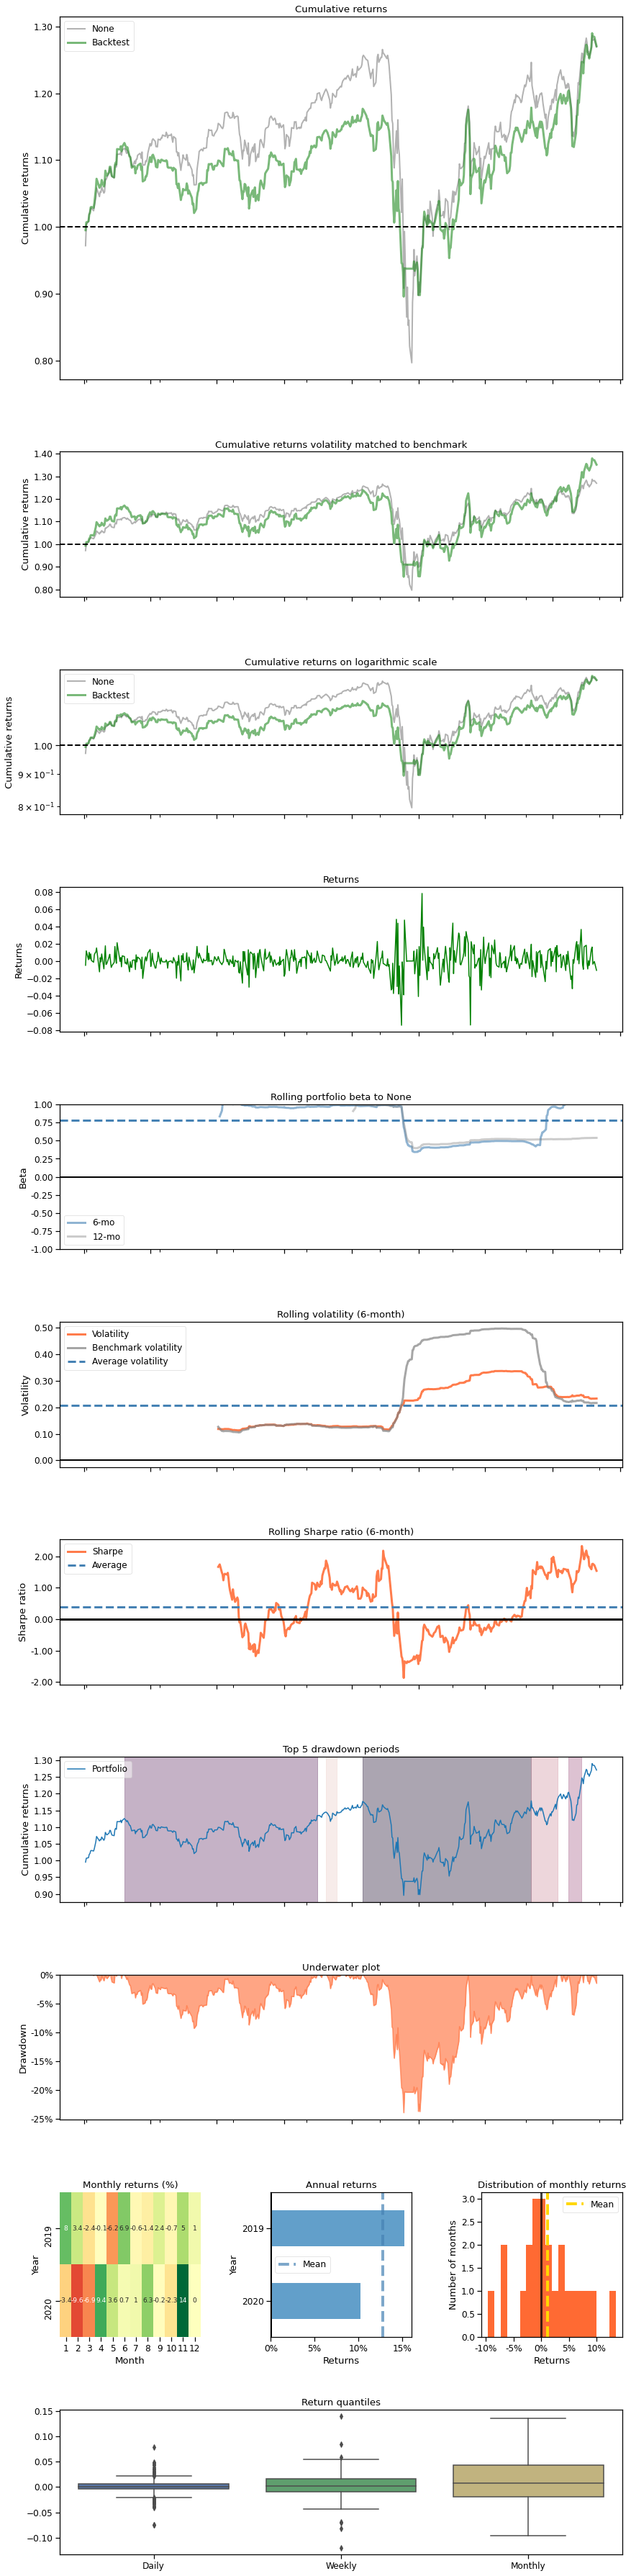

In [37]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
BackTestPlot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2020-12-01')

<a id='6.3'></a>
## 7.3 Baseline Stats

In [38]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('^DJI',
                                  baseline_start = '2019-01-01',
                                  baseline_end = '2020-12-01')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (483, 7)
Annual return          0.132593
Cumulative returns     0.269525
Annual volatility      0.280347
Sharpe ratio           0.586312
Calmar ratio           0.357526
Stability              0.060828
Max drawdown          -0.370862
Omega ratio            1.137261
Sortino ratio          0.807330
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.844803
Daily value at risk   -0.034668
Alpha                  0.000000
Beta                   1.000000
dtype: float64
